# DEEP NEURAL NETWORK 

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
sns.set_theme(style='darkgrid', palette='hls')

import torch 
from torchvision.transforms import ToTensor
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score

### Tabular data

In [2]:
class Dataset_Custom(Dataset):
    def __init__(self, X_data, Y_data):
        X_data = X_data
        Y_data = Y_data
        self.x, self.y = self.clean(X_data, Y_data)
        self.samples = self.y.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] 

    def __len__(self):
        return self.samples

    def clean(self,X_data,Y_data):
        scaler = StandardScaler()
        data_x = scaler.fit_transform(X_data)
        x = torch.from_numpy(data_x).float()
        y = torch.from_numpy(Y_data.values).float()
        y = y[:,None]
        return x,y


### Separating into training and testing

In [3]:
file = './data_processed/embeddings_spacy.csv'
data = pd.read_csv(file, index_col=0)

X = data.iloc[:,:-1]
y = data[data.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, shuffle=True)

print("X_train {} y_train {} \nX_test {} y_test {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

dataset_train = Dataset_Custom(X_train, y_train)
dataset_test = Dataset_Custom(X_test, y_test)

X_train (5482, 99) y_train (5482,) 
X_test (1371, 99) y_test (1371,)


### Using DataLoaders for both sets

In [4]:
batch = 30

trainloader = DataLoader(dataset=dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset=dataset_test, batch_size=batch, shuffle=True)

### Function to build the model

In [5]:
def build_model(input_size, hidden_sizes, output_size, activation_functions):
    layers = []
    layer_sizes = [input_size] + hidden_sizes + [output_size]
    
    # Add hidden layers
    for i in range(1, len(layer_sizes)):
        layers.append(('fc{}'.format(i), nn.Linear(layer_sizes[i-1], layer_sizes[i])))
        if activation_functions[i-1] == 'relu':
            layers.append(('relu{}'.format(i), nn.ReLU()))
        elif activation_functions[i-1] == 'sigmoid':
            layers.append(('sigmoid{}'.format(i), nn.Sigmoid()))

    model = nn.Sequential(OrderedDict(layers))
    return model

### Training the model

In [6]:
# Definition of loss, learning rate & epochs
def train_rna(model):
    learning_rate = 0.01

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    epochs = 100
    print_every = int((X_train.shape[0]/batch) / 20)
    steps = 0 
    list_loss = []
    list_loss_test = []
    list_epochs = []

    # Comenzando entrenamiento. . . 
    for e in range(epochs):
        running_loss = 0
        # En cada epoca cargamos todos los batches 
        for inputs, labels in iter(trainloader):
            steps += 1
            # Reiniciar los gradientes
            optimizer.zero_grad()
            # Forward pass
            outputs = model.forward(inputs)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backprogation
            loss.backward()
            # Actualiza los pesos de acuerdo a un paso del optimizador
            optimizer.step()
            # Guardamos la perdida para control del entrenamiento
            running_loss += loss.item()
            # imprimimos cada 20% lotes
            if steps % print_every == 0:
                list_loss.append(running_loss/print_every)
                running_loss = 0
                
                output_test = model.forward(dataset_test.x)
                loss_t = criterion(output_test, dataset_test.y)
                list_loss_test.append(loss_t.item())
                list_epochs.append(e+1)
            
    df = pd.DataFrame()
    df['epochs'] = list_epochs
    df['loss_train'] = list_loss
    df['loss_test'] = list_loss_test

    sns.set_theme(style="darkgrid")

    sns.lineplot(x="epochs", y="loss_train", data=df, color='yellow', label='Entrenamiento')
    sns.lineplot(x="epochs", y="loss_test", data=df, color='violet', label='Prueba')

    output_acc = model.forward(dataset_test.x)

    # Medidas
    pred = torch.unsqueeze(torch.tensor([ 0 if p<=0.5 else 1 for p in output_acc]),1)
    label = dataset_test.y
    pred = pred.numpy()
    label = label.numpy()

    # Calcular la exactitud
    exactitud = round(accuracy_score(label, pred),2)
    #print("Exactitud:", exactitud)

    # Calcular la preci sión
    precision = round(precision_score(label, pred),2)
    #print("Precisión:", precision)

    # Calcular la puntuación F1
    f1 = round(f1_score(label, pred),2)
    #print("Puntuación F1:", f1)

    print("Exactitud (Accuracy):", exactitud)
    print("Precisión (Precision):", precision)
    print("F1-score:", f1)

Exactitud (Accuracy): 0.54
Precisión (Precision): 0.53
F1-score: 0.54


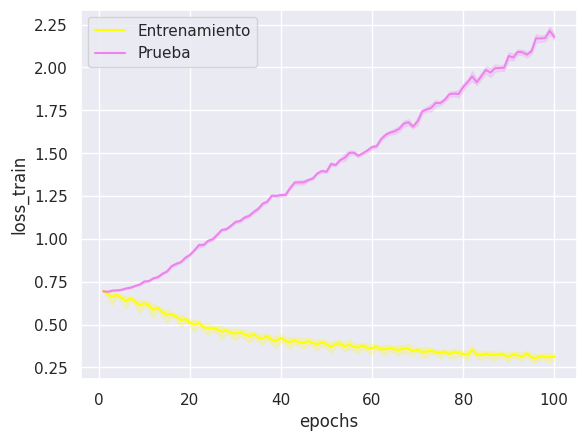

In [14]:
modelo = build_model(X.shape[1], [22], 1, ['relu','sigmoid'])
train_rna(modelo)

### Algoritmo genético para optimizar la estructura de la red

In [ ]:
# Generacion de la poblacion inicial
# 5 redes 1 capa oculta , 5 redes 2 capa oculta , 5 redes 3 capa oculta , 5 redes 4 capa oculta
# No. Neuronas por capa (3, 50)
no_individuos = 40
input_size = X.shape[1]
output_size = 1


individuos = []
# -------------------------- Generacion de la poblacion inicial -----------------------------------------

# Generamos las caracteristicas de los individuos
for i in range(4):
    # Redes
    for j in range(10):
        individuo = {'input_size': input_size ,'hidden_sizes':[] , 'activation':[], 'output_size' : output_size , 'fit' : 0.0}
        for k in range(i+1):
            individuo['hidden_sizes'].append(np.random.randint(3,51))
            individuo['activation'].append('relu')
        individuo['activation'].append('sigmoid')
        individuos.append(individuo)

# -------------------------- Funcion para generar los modelos a partir de sus caracteristicas ---------------

# Generamos los individuos en base a las caracteristicas
def generateNetworks(individuos):
    networks = []
    for item in individuos:
        networks.append(build_model(item['input_size'], item['hidden_sizes'] , item['output_size'], item['activation']))
    return networks

# -------------------------- Evaluacion del modelo -------------------

# Evaluation
def fitness(networks:list, individuos):
    for no in range(no_individuos):
        individuos[no]['fit'] = train_rna(networks[no])  
    return individuos

# -------------------------- Seleccion (7 mejores y 3 peores) -------------------

# Selection
def selection(individuos):
    individuos = sorted(individuos, key=lambda x: x['fit'], reverse=True)
    # Se seleccionan los mejores 7 y los ultimos 3 
    individuos = individuos[0:14] + individuos[-6:]
    return individuos

# -------------------------- Cruza y mutacion -------------------

def CrossoverAndMutation(individuos):
    # Aleatorizamos los individuos seleccionados para agregar diversidad y evitar elitismo
    # Cross-over and mutation 5 new -> cross over 5 -> mutation
    random.shuffle(individuos)

    # Cross-over
    for i in range(0,len(individuos),2):
        individuo = {'input_size': input_size ,'hidden_sizes':[] , 'activation':[], 'output_size' : output_size , 'fit' : 0.0}
        # Aleatoria un numero para saber que capas va a heredar
        if np.random.randint(0,2) == 0:
            individuo['hidden_sizes'] = individuos[i]['hidden_sizes'].copy()
            individuo['activation'] = individuos[i]['activation'].copy()
            individuo['hidden_sizes'][np.random.randint(0,len(individuo['hidden_sizes']))] = individuos[i+1]['hidden_sizes'][np.random.randint(0,len(individuos[i+1]['hidden_sizes']))]
        else :
            individuo['hidden_sizes'] = individuos[i+1]['hidden_sizes'].copy()
            individuo['activation'] = individuos[i+1]['activation'].copy()
            individuo['hidden_sizes'][np.random.randint(0,len(individuo['hidden_sizes']))] = individuos[i]['hidden_sizes'][np.random.randint(0,len(individuos[i]['hidden_sizes']))]
        
        individuos.append(individuo)
        
    # Mutations
    mutations = []
    while len(mutations) != int(no_individuos/4):
        index = np.random.randint(0,len(individuos))
        if len(mutations) == 0:
            mutations.append(index)
        else:
            if index not in mutations:
                mutations.append(index)
    # Copiar un gen == 1 
    # Crear nuevo gen == 0
    for mutation in mutations:
        individuo = {'input_size': input_size ,'hidden_sizes':[] , 'activation':[], 'output_size' : output_size , 'fit' : 0.0}
        individuo['hidden_sizes'] = individuos[mutation]['hidden_sizes'].copy()
        individuo['activation'] = individuos[mutation]['activation'].copy()

        if np.random.randint(0,2) == 0 or len(individuo['hidden_sizes']) == 1:
            individuo['hidden_sizes'][np.random.randint(0,len(individuo['hidden_sizes']))] = np.random.randint(3,51)
        else:
            id_ = np.random.randint(0,len(individuo['hidden_sizes']))
            id_new = np.random.randint(0,len(individuo['hidden_sizes']))
            while id_ == id_new:
                id_new = np.random.randint(0,len(individuo['hidden_sizes']))
            individuo['hidden_sizes'][id_] = individuo['hidden_sizes'][id_new]

        individuos.append(individuo)
        
    return individuos

def criteria(individuos):
    individuos = sorted(individuos, key=lambda x: x['fit'], reverse=True)
    print('Mejor aptitud para esta generación: ', individuos[0]['fit'])
    print(individuos[0])
    if individuos[0]['fit'] >= 0.65:
        file = open('./GeneticsResults.txt', mode='w',encoding='utf-8')
        file.write('Arquitectura encontrada!\n')
        file.write(str(individuos[0]))
        file.close()
        return True
    else: 
        return False

# -------------------------- ALGORITMO GENETICO -------------------
"""
# Evaluar la poblacion inicial
noGeneracion = 0
networks = generateNetworks(individuos) # Generar modelos usando caracteristicas
individuos = fitness(networks, individuos) # Evaluamos cada modelo
print('Generacion ',noGeneracion)
paro = criteria(individuos) # Revisar si se encontro un modelo útil
print(len(individuos))
while not paro:
    individuos = selection(individuos) # Seleccionamos los mejores (%50) 
    individuos = CrossoverAndMutation(individuos) # Cruza (25%) y (2)
    networks = generateNetworks(individuos) 
    individuos = fitness(networks, individuos)
    noGeneracion += 1
    print('Generacion ',noGeneracion)
    paro = criteria(individuos) """

Generacion  0
Mejor aptitud para esta generación:  0.55
{'input_size': 99, 'hidden_sizes': [47], 'activation': ['relu', 'sigmoid'], 'output_size': 1, 'fit': 0.55}
40
Generacion  1
Mejor aptitud para esta generación:  0.56
{'input_size': 99, 'hidden_sizes': [48, 11, 35, 35], 'activation': ['relu', 'relu', 'relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.56}


/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generacion  2
Mejor aptitud para esta generación:  0.56
{'input_size': 99, 'hidden_sizes': [45, 5], 'activation': ['relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.56}
Generacion  3
Mejor aptitud para esta generación:  0.55
{'input_size': 99, 'hidden_sizes': [5], 'activation': ['relu', 'sigmoid'], 'output_size': 1, 'fit': 0.55}


/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generacion  4
Mejor aptitud para esta generación:  0.55
{'input_size': 99, 'hidden_sizes': [47, 47, 8, 8], 'activation': ['relu', 'relu', 'relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.55}
Generacion  5
Mejor aptitud para esta generación:  0.55
{'input_size': 99, 'hidden_sizes': [21, 8], 'activation': ['relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.55}


/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generacion  6
Mejor aptitud para esta generación:  0.55
{'input_size': 99, 'hidden_sizes': [12, 33], 'activation': ['relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.55}
Generacion  7
Mejor aptitud para esta generación:  0.56
{'input_size': 99, 'hidden_sizes': [22, 45, 19], 'activation': ['relu', 'relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.56}


/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generacion  8
Mejor aptitud para esta generación:  0.56
{'input_size': 99, 'hidden_sizes': [7, 25, 37, 27], 'activation': ['relu', 'relu', 'relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.56}


/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generacion  9
Mejor aptitud para esta generación:  0.56
{'input_size': 99, 'hidden_sizes': [47, 36, 46, 19], 'activation': ['relu', 'relu', 'relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.56}


/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generacion  10
Mejor aptitud para esta generación:  0.56
{'input_size': 99, 'hidden_sizes': [8, 8], 'activation': ['relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.56}


/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generacion  11
Mejor aptitud para esta generación:  0.55
{'input_size': 99, 'hidden_sizes': [17, 17, 45, 12], 'activation': ['relu', 'relu', 'relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.55}


/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generacion  12
Mejor aptitud para esta generación:  0.56
{'input_size': 99, 'hidden_sizes': [21, 22, 3], 'activation': ['relu', 'relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.56}


/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno-rg/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Generacion  13
Mejor aptitud para esta generación:  0.55
{'input_size': 99, 'hidden_sizes': [17, 3, 3], 'activation': ['relu', 'relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.55}
Generacion  14
Mejor aptitud para esta generación:  0.55
{'input_size': 99, 'hidden_sizes': [47, 19, 32, 7], 'activation': ['relu', 'relu', 'relu', 'relu', 'sigmoid'], 'output_size': 1, 'fit': 0.55}


KeyboardInterrupt: 